In [6]:
import os
import sys
import json
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import skimage.io

# sys.path.append(os.path.dirname(os.path.abspath(__file__)))
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)
from mrcnn import visualize, utils
from mrcnn.model import log
# from mrcnn.visualize import display_images, draw_box
# from mrcnn.utils import minimize_mask, expand_mask


In [17]:
class OcclusionDataset(utils.Dataset):

    def load_occlusion(self, dataset_dir, subset, class_ids=None,
                       return_occlusion=False):
        occlusion = COCO(
            r"d:\Users\ROG\Desktop\FYP\Mask_RCNN-Occulusion\surgical_data\samples\bad\surgical_sample_bad2.json")

        image_dir = r'd:\Users\ROG\Desktop\FYP\Mask_RCNN-Occulusion\surgical_data\samples'
        # image_dir = "{}/{}{}".format(dataset_dir, subset, year)

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(occlusion.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(occlusion.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(occlusion.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("occlusion", i, occlusion.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "occlusion", image_id=i,
                path=os.path.join(image_dir, occlusion.imgs[i]['file_name']),
                width=occlusion.imgs[i]["width"],
                height=occlusion.imgs[i]["height"],
                annotations=occlusion.loadAnns(occlusion.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_occlusion:
            return occlusion


    def load_mask(self, image_id, mask_format='polygon'):
        image_info = self.image_info[image_id]
        if image_info["source"] != "occlusion":
            return super(OcclusionDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "occlusion.{}".format(annotation['category_id']))
            if class_id:
                if mask_format == 'polygon':
                    m = self.annToMask(annotation, image_info["height"],
                                       image_info["width"])
                elif mask_format == 'bitmap':
                    m = np.array(annotation['segmentation'])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(OcclusionDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "occlusion":
            return info['id']
        else:
            super(OcclusionDataset, self).image_reference(image_id)


    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle


    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(r"d:\Users\ROG\Desktop\FYP\Mask_RCNN-Occulusion\surgical_data\samples\00021.jpg")
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image




loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


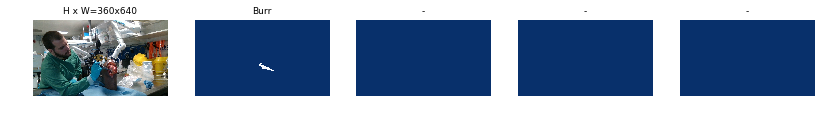

image_id  0 00021_2
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (360, 640, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  202.00000  max:  374.00000  int32


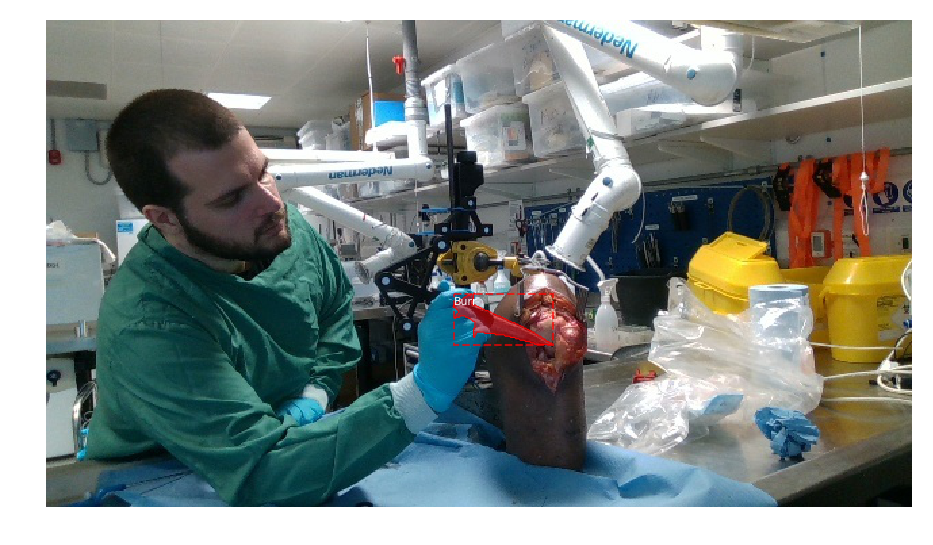

In [18]:
dataset_dir = os.path.abspath('samples/')
annos_dir = os.path.join(dataset_dir, 'bad')
images_dir = dataset_dir


dataset = OcclusionDataset()
occlusion = dataset.load_occlusion(dataset_dir, "test", return_occlusion=True)
dataset.prepare()

target_id = "00021"
for i in range(len(dataset.image_info)):
    if dataset.image_info[i]['id'] == target_id:
        target_idx = i
        break

%matplotlib inline
# n = 1
image_ids = [target_idx]
# image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    info = dataset.image_info[image_id]
    # ======================== Load image ==================================
    # image_id = random.choice(dataset.image_ids)
    image = dataset.load_image(image_id)
    # visualize.display_images([images], cols=1)


    # ========================= Display images and masks ===================
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    # plt.figure()
    # plt.title('manual_mask')
    # plt.axis('off')
    # plt.imshow(mask[:, :, 0].astype(np.uint8))
    # plt.show()
    
    # ============================== Bounding boxes =========================
    # Load mask
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)




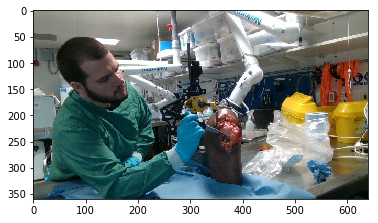

In [15]:

plt.imshow(image.astype(np.uint8))

In [10]:
plt.show()

D:\Downloads\anaconda3\envs\mrcnn\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [19]:
import numpy as np
from PIL import Image, ImageOps

# Load the image
img = Image.open('image_to_shear.png')

# Define the shear angle in degrees
angle = 45

# Calculate the horizontal and vertical shear amounts based on the angle
h_shear = img.size[1] * np.tan(np.radians(angle))
v_shear = img.size[0] * np.tan(np.radians(angle))

# Apply the shear transformation using the affine() function
sheared_img = img.transform(img.size, Image.AFFINE, (1, h_shear, 0, v_shear, 1, 0))

# Flip the image horizontally to correct the orientation
sheared_img = ImageOps.mirror(sheared_img)

# Show the sheared image
sheared_img.show()